In [1]:
from class_DataContainer import DataContainer # class for data loading and preprocessing

#data manipulation imports
import pandas as pd 
import numpy as np

#regressor imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#visualisation imports
import matplotlib.pyplot as plt

In [2]:
data = DataContainer('./CarPrice_Assignment.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int16  
 1   symboling         205 non-null    int8   
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float32
 10  carlength         205 non-null    float32
 11  carwidth          205 non-null    float32
 12  carheight         205 non-null    float32
 13  curbweight        205 non-null    int16  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int16  
 1

In [3]:
data.encode_str(exclude='CarName')
data.info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int16  
 1   symboling         205 non-null    int8   
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    int8   
 4   aspiration        205 non-null    int8   
 5   doornumber        205 non-null    int8   
 6   carbody           205 non-null    int8   
 7   drivewheel        205 non-null    int8   
 8   enginelocation    205 non-null    int8   
 9   wheelbase         205 non-null    float32
 10  carlength         205 non-null    float32
 11  carwidth          205 non-null    float32
 12  carheight         205 non-null    float32
 13  curbweight        205 non-null    int16  
 14  enginetype        205 non-null    int8   
 15  cylindernumber    205 non-null    int8   
 16  enginesize        205 non-null    int16  
 1

In [4]:
#Feature Engineering
data.data['avg_mpg'] =(data.data['highwaympg'] + data.data['citympg'])/2 #average fuel consumption in mpg
data.data['torque'] = ((data.data['horsepower'] / 5252) * data.data['peakrpm']) #torque in lb-ft

data.split_data(label='price', drop=['car_ID','CarName'])

In [5]:
#Random Forest Setup
X_train, X_test, y_train, y_test = train_test_split(data.features, data.label, test_size=0.2, random_state=99)

params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10],
    'criterion': ['squared_error', 'absolute_error','friedman_mse', 'poisson']}

rf = RandomForestRegressor()
gsrf = GridSearchCV(rf, params, cv=5, n_jobs=-1)

gsrf.fit(X_train, y_train)
optimal_params_rf = gsrf.best_params_

rf.set_params(**optimal_params_rf)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)


0.9015588468695213

In [6]:
pred_rf = rf.predict(X_test)

def percent_change(pred, y_test):
    return (np.abs(y_test - pred) / (np.abs(y_test) / 2)) * 100

percent_error_rf = np.array([percent_change(x,y) for x,y in zip(pred_rf, y_test)])
range_dict_rf = {'0-10%': len([x for x in percent_error_rf if x <= 10]), 
              '10-20%': len([x for x in percent_error_rf if x > 10 and x <= 20]), 
              '20-30%': len([x for x in percent_error_rf if x > 20 and x <= 30]), 
              '30-40%': len([x for x in percent_error_rf if x > 30 and x <= 40]), 
              '40-50%': len([x for x in percent_error_rf if x > 40 and x <= 50]), 
              '50-60%': len([x for x in percent_error_rf if x > 50 and x <= 60]), 
              '60-70%': len([x for x in percent_error_rf if x > 60 and x <= 70]), 
              '70-80%': len([x for x in percent_error_rf if x > 70 and x <= 80]), 
              '80-90%': len([x for x in percent_error_rf if x > 80 and x <= 90]), 
              '90-100%': len([x for x in percent_error_rf if x > 90 and x <= 100])}

mean_error_rf = np.mean(percent_error_rf)
median_error_rf = np.median(percent_error_rf)

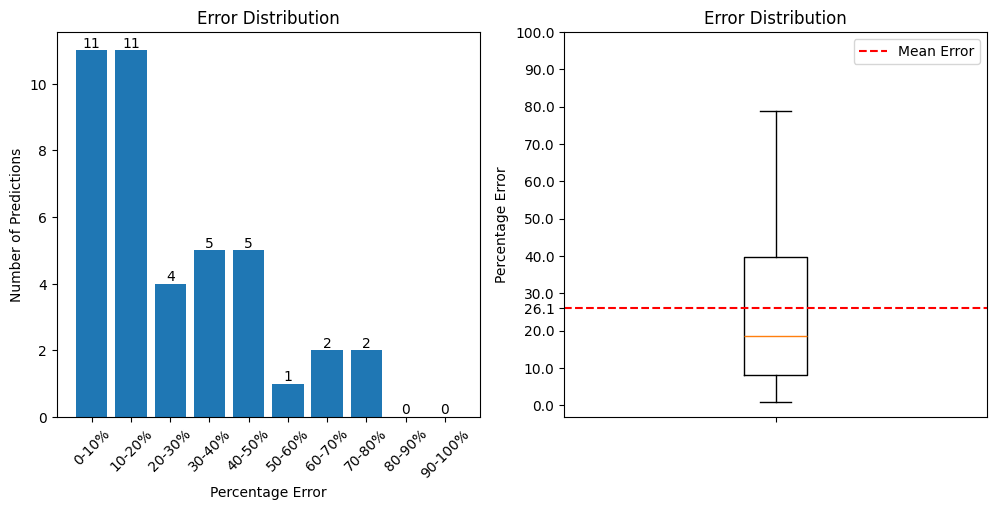

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.bar(range_dict_rf.keys(), range_dict_rf.values())
plt.xticks(rotation=45)
plt.xlabel('Percentage Error')
plt.ylabel('Number of Predictions')
plt.title('Error Distribution')

# Add counts to the plot
for i, count in enumerate(range_dict_rf.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')


plt.subplot(1,2,2)
plt.boxplot(percent_error_rf)
plt.ylabel('Percentage Error')
plt.title('Error Distribution')


plt.axhline(mean_error_rf, color='red', linestyle='--', label='Mean Error')
plt.yticks(np.append(np.array(np.arange(0,101,10)), mean_error_rf))
plt.xticks([1], [None])

plt.legend()
plt.show()
plt.clf()

In [8]:
#Linear Regression Setup
'''StandardScaler and MinMaxScaler both reduce prediction accuracy of LinearRegressoion with this dataset.
In comparison to non-scaled data, the fit score is reduced by approx. 10% and approx. 30% respectively.
Hyperparameter tuning is not expected to have a significant impact on the fit score, but is included for a fair comparrison with RandomForrest.
'''

lr = LinearRegression()

lr_params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1]}

#Set up grid search
gslr = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1)

#Fit data to grid search
gslr.fit(X_train, y_train)
optimal_params_lr = gslr.best_params_

#Set optimal parameters
lr.set_params(**optimal_params_lr)

#Fit data to linear regression
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8478099419230305

In [9]:
pred_lr = lr.predict(X_test)

percent_error_lr = np.array([percent_change(x,y) for x,y in zip(pred_lr, y_test)])
range_dict_lr = {'0-10%': len([x for x in percent_error_lr if x <= 10]), 
              '10-20%': len([x for x in percent_error_lr if x > 10 and x <= 20]), 
              '20-30%': len([x for x in percent_error_lr if x > 20 and x <= 30]), 
              '30-40%': len([x for x in percent_error_lr if x > 30 and x <= 40]), 
              '40-50%': len([x for x in percent_error_lr if x > 40 and x <= 50]), 
              '50-60%': len([x for x in percent_error_lr if x > 50 and x <= 60]), 
              '60-70%': len([x for x in percent_error_lr if x > 60 and x <= 70]), 
              '70-80%': len([x for x in percent_error_lr if x > 70 and x <= 80]), 
              '80-90%': len([x for x in percent_error_lr if x > 80 and x <= 90]), 
              '90-100%': len([x for x in percent_error_lr if x > 90 and x <= 100])}

mean_error_lr = np.mean(percent_error_lr)
median_error_lr = np.median(percent_error_lr)

percent_error_lr

array([17.78578968,  3.04568244,  2.64947677, 63.57764211, 40.59333824,
       16.50271772, 42.27647186,  0.96524194,  0.81038844, 32.06560432,
        4.73116395, 84.34278507, 19.36830133, 34.12885511, 15.07809483,
       12.84163409,  4.55783074, 68.01355276, 18.12610936, 52.11887228,
       11.41549458,  7.09181534, 18.01891454, 44.8896745 ,  2.90652072,
       70.513978  , 78.33026621, 45.0527949 , 68.67808036, 49.06973149,
       46.24014583,  9.80402057, 18.10324659,  0.9580763 , 12.6256539 ,
       49.87018307, 39.27811446, 49.62424962, 30.39299518, 25.44441132,
       25.28317923])

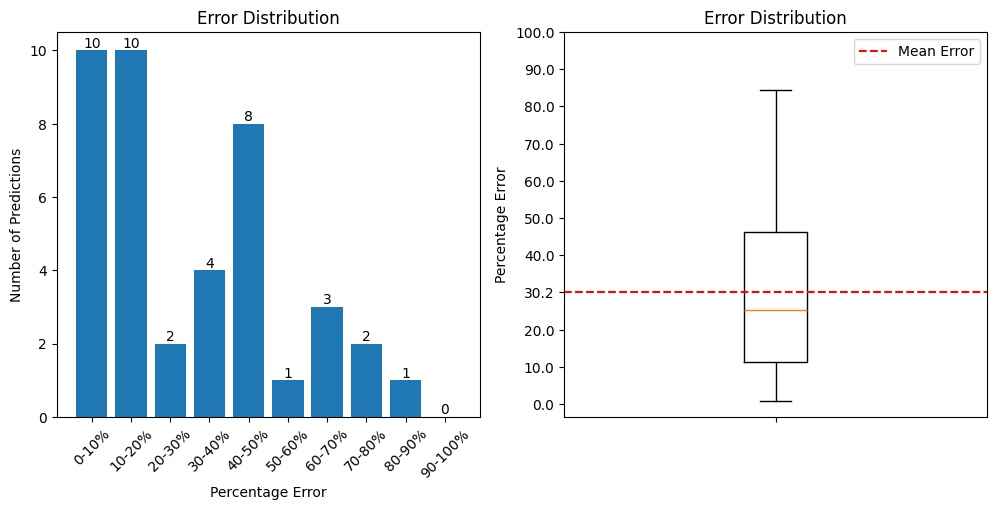

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.bar(range_dict_lr.keys(), range_dict_lr.values())
plt.xticks(rotation=45)
plt.xlabel('Percentage Error')
plt.ylabel('Number of Predictions')
plt.title('Error Distribution')

# Add counts to the plot
for i, count in enumerate(range_dict_lr.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')


plt.subplot(1,2,2)
plt.boxplot(percent_error_lr)
plt.ylabel('Percentage Error')
plt.title('Error Distribution')


plt.axhline(mean_error_lr, color='red', linestyle='--', label='Mean Error')
plt.yticks(np.append(np.delete(np.array(np.arange(0,101,10)), 3), mean_error_lr))
plt.xticks([1], [None])

plt.legend()
plt.show()
plt.clf()

Mean-Median Comparison: 
RF:  Mean:26.132699533523375 | Median: 18.51069383568668 
LR: Mean: 30.17490487096574 | Median: 25.28317922542202


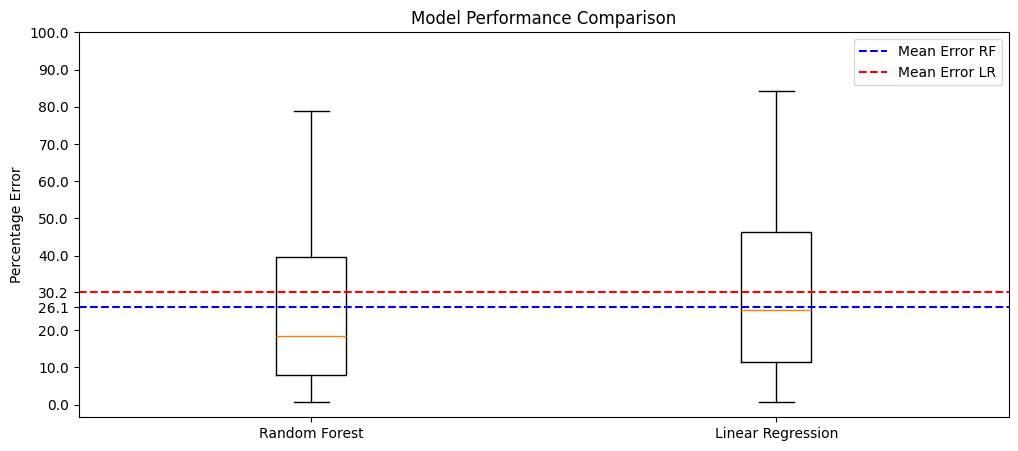

In [11]:
print(f"Mean-Median Comparison: \nRF:  Mean:{mean_error_rf} | Median: {median_error_rf} \nLR: Mean: {mean_error_lr} | Median: {median_error_lr}")
plt.figure(figsize=(12, 5))
plt.boxplot([percent_error_rf, percent_error_lr])
plt.ylabel('Percentage Error')
plt.title('Model Performance Comparison')
plt.xticks([1, 2], ['Random Forest', 'Linear Regression'])
plt.yticks(np.append(np.delete(np.array(np.arange(0,101,10)),3), [mean_error_rf, mean_error_lr]))

plt.axhline(mean_error_rf, color='blue', linestyle='--', label='Mean Error RF')
plt.axhline(mean_error_lr, color='red', linestyle='--', label='Mean Error LR')
plt.legend()

plt.show()

In [29]:
#RF outliers (error > 70%)
outliers_rf = []
for i, x in enumerate(percent_error_rf):
    if x > 70:
        print(f"RF: -> Error: {x} | Actual: {y_test.iloc[i]} | Prediction {pred_rf[i]} | Car Name: {data.data[data.data['price'] == y_test.iloc[i]]['CarName']}")
        outliers_rf.append(y_test.iloc[i])
        
data.data.query('price in @outliers_rf')

RF: -> Error: 74.22751448743871 | Actual: 18344.0 | Prediction 11535.85237121212 | Car Name: 66    mazda rx-7 gs
Name: CarName, dtype: object
RF: -> Error: 78.91749115476738 | Actual: 6785.0 | Prediction 9462.275887425483 | Car Name: 43    isuzu MU-X
Name: CarName, dtype: object


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,avg_mpg,torque
43,44,0,isuzu MU-X,0,0,1,2,0,0,94.300003,...,3.31,3.23,8.5,78,4800,24,29,6785.0,26.5,71.287129
66,67,0,mazda rx-7 gs,1,0,1,2,0,0,104.900002,...,3.43,3.64,22.0,72,4200,31,39,18344.0,35.0,57.578065


In [27]:
#LR outliers (error > 70%)
outliers_lr = []
for i, x in enumerate(percent_error_lr):
    if x > 70:
        print(f"LR: -> Error: {x} | Actual: {y_test.iloc[i]} | Prediction {pred_lr[i]} | Car Name: {data.data[data.data['price'] == y_test.iloc[i]]['CarName']}" )
        outliers_lr.append(y_test.iloc[i])
        
data.data.query('price == @outliers_lr')
        

LR: -> Error: 84.34278507019457 | Actual: 8449.0 | Prediction 12012.06095529037 | Car Name: 167    toyota corona liftback
Name: CarName, dtype: object
LR: -> Error: 70.51397799801869 | Actual: 18344.0 | Prediction 11876.457938021726 | Car Name: 66    mazda rx-7 gs
Name: CarName, dtype: object
LR: -> Error: 78.33026621317481 | Actual: 13860.0 | Prediction 19288.287448573014 | Car Name: 110    peugeot 504
Name: CarName, dtype: object


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,avg_mpg,torque
66,67,0,mazda rx-7 gs,1,0,1,2,0,0,104.900002,...,3.43,3.64,22.0,72,4200,31,39,18344.0,35.0,57.578065
110,111,0,peugeot 504,1,1,1,3,0,0,114.199997,...,3.70,3.52,21.0,95,4150,25,25,13860.0,25.0,75.066641
167,168,2,toyota corona liftback,0,0,0,4,0,0,98.400002,...,3.62,3.50,9.3,116,4800,24,30,8449.0,27.0,106.016756
